In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shelve
%matplotlib inline

# load the scraped data from file
f = shelve.open('scraped_data.shelf', flag='r')
df = f['df']
f.close()


# split the dataframe by car model & year
data = {}
for car in df['car'].unique():
    data[car] = {}
    data[car][2013] = df[(df['car'] == car) & (df['year'] == 2013)]
    data[car][2014] = df[(df['car'] == car) & (df['year'] == 2014)]
    data[car][2015] = df[(df['car'] == car) & (df['year'] == 2015)]
    data[car][2016] = df[(df['car'] == car) & (df['year'] == 2016)]
    
    
# define the average maintenance costs and mileage per year
# assuming 12000 miles/year
avg_miles_per_year = 12000.

# assuming $200 per year at year 0 and $2000 per year at year 20
maint_per_year_year0 = 200.
maint_per_year_year20 = 2000.

# assuming a linear yearly increase throughout lifespan
maint_per_mile_year0 = maint_per_year_year0 / avg_miles_per_year
maint_per_mile_year20 = maint_per_year_year20 / avg_miles_per_year

maintpermile_vs_miles_m = (maint_per_mile_year20 - maint_per_mile_year0) / (20.*avg_miles_per_year - 0.)
maintpermile_vs_miles_b = maint_per_mile_year0

def get_avg_maint_cost_per10k(start_mileage, end_mileage):
    if end_mileage > 240000:
        end_mileage = 240000
    
    avg_maint_cpm = maintpermile_vs_miles_b + \
                    maintpermile_vs_miles_m*(start_mileage+end_mileage)/2.
    
    return 10000*avg_maint_cpm

# define cutting the data by mileage
def mileage_cut(data, mileage):
    subset = {}
    for car in data:
        subset[car] = {}
        for year in data[car]:
            subset[car][year] = data[car][year][data[car][year]['mileage'] <= mileage]
            
    return subset

## How do used car prices trend with mileage and model year?

Price vs Mileage

Shown is the Rav4
Price is the median price you'd expect to pay

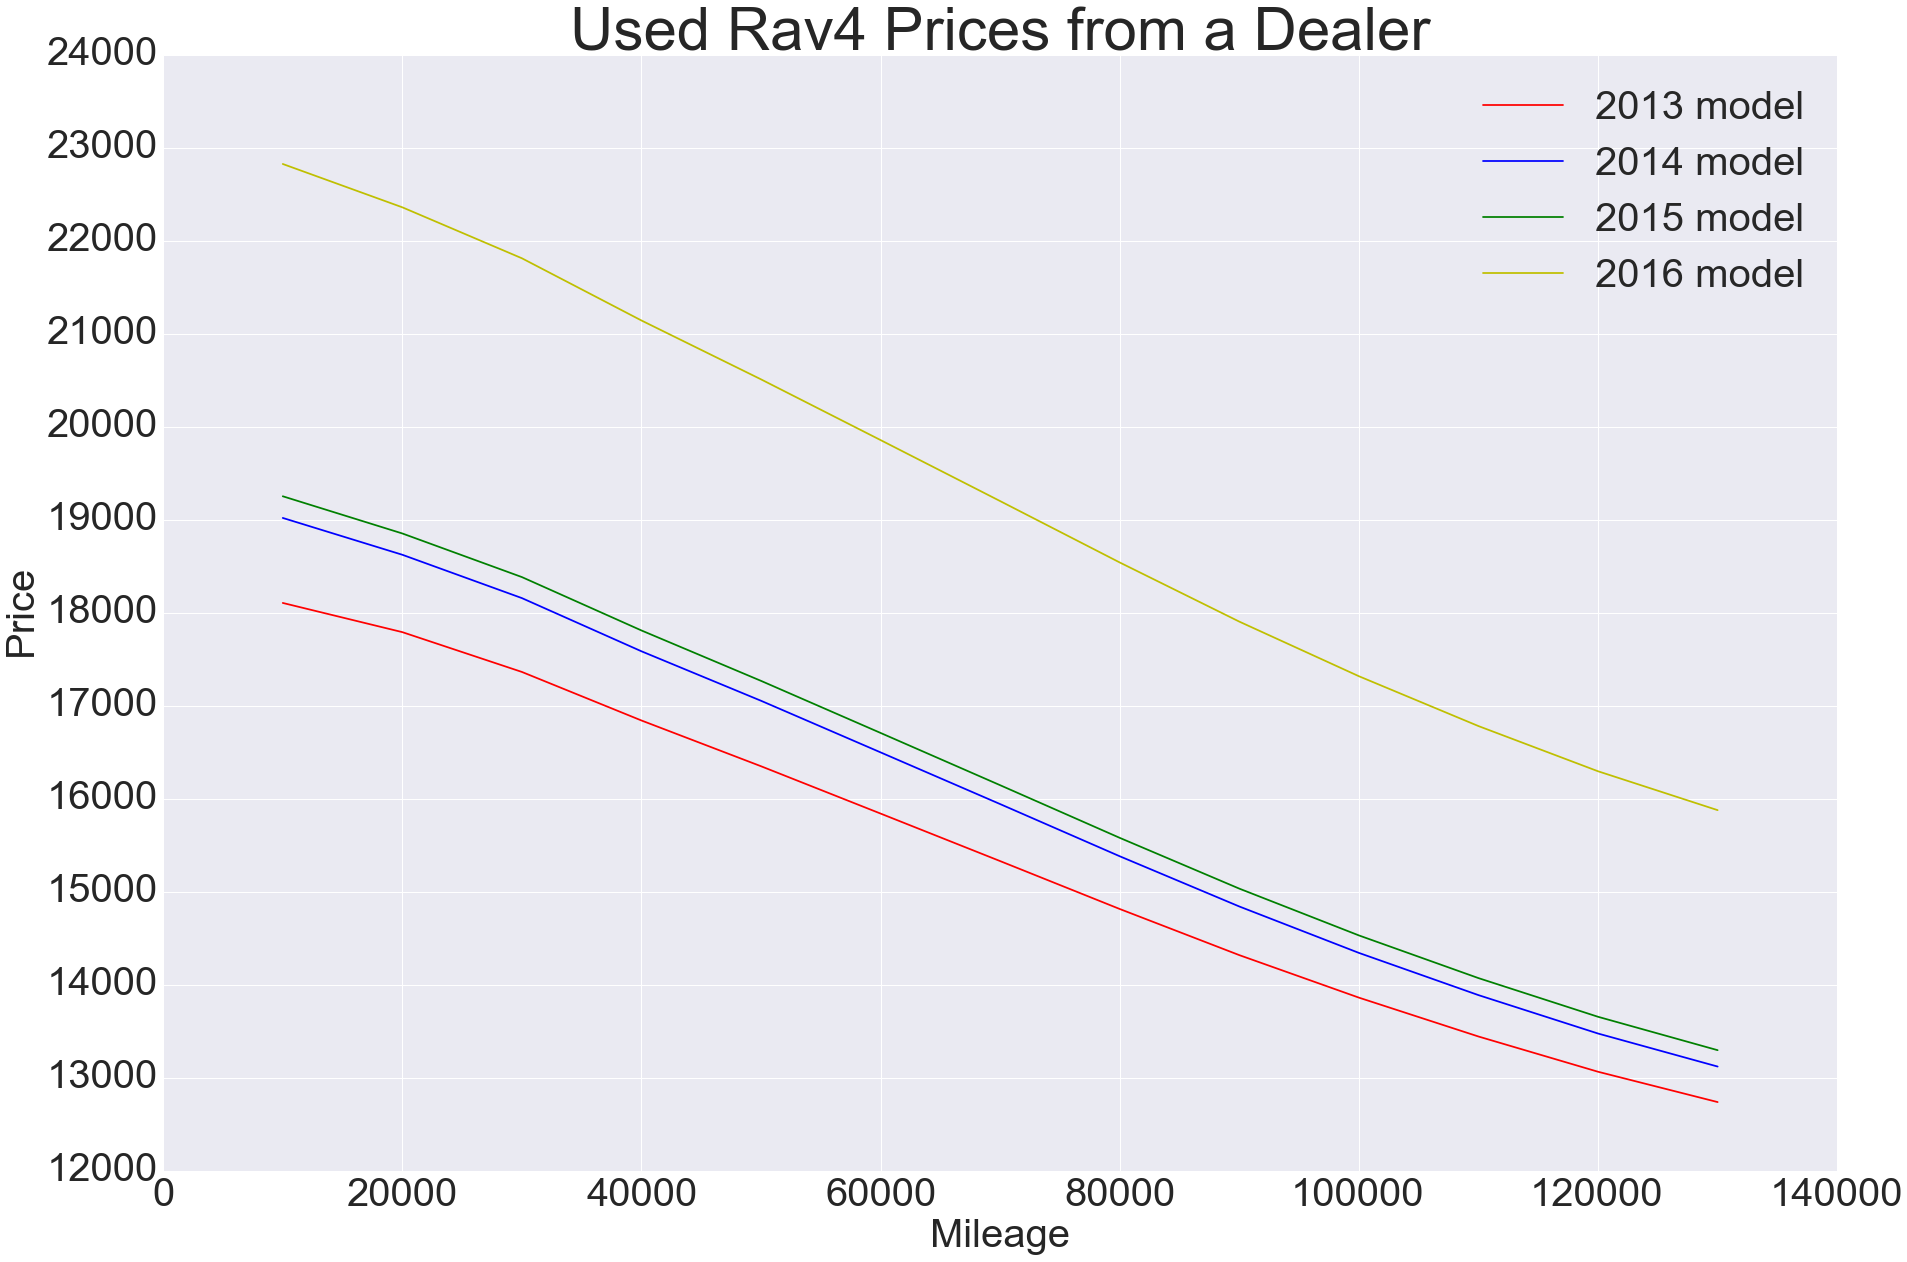

In [17]:
subset = mileage_cut(data, 130000)

car = 'rav4'
fig, ax = plt.subplots()
height = 20
fig.set_figheight(height)
width = 30
fig.set_figwidth(width)
ax.set_title('Used %s Prices from a Dealer' % car.title(), fontsize=width*2)
ax.set_xlabel('Mileage', fontsize=height*2)
ax.set_ylabel('Price', fontsize=height*2)
ax.tick_params(axis='y', labelsize=height*2)
ax.tick_params(axis='x', labelsize=height*2)
ax.ticklabel_format()

dealer = {}
colors = {2013:'r', 2014:'b', 2015:'g', 2016:'y'}

for year in [2013, 2014, 2015, 2016]:
    dealer[year] = ax.plot(subset[car][year].mileage, 
                           subset[car][year].dealer, 
                           c=colors[year])

ax.legend([(dealer[2013][0]), 
            (dealer[2014][0]), 
            (dealer[2015][0]),
           (dealer[2016][0])
          ], 
           ['2013 model', 
            '2014 model', 
            '2015 model',
            '2016 model'
           ],
          fontsize=height*2)

ax.set_yticks(np.arange(ax.get_yticks()[0], ax.get_yticks()[-1]+1000, 1000))

plt.show()

## How do these trends differ between similar car models?

Look at each model on a "low mileage price" vs "high mileage price" plot.

Each region of the plot can be interpreted as labeled: a car being "cheaper" vs "more expensive" is determined by it's position diagonally bottom-left to top-right. and a car's rate of price decay is shown by it's position diagonally top-left to bottom-right.

This gives us a sense of how the car models compare. The Santa Fe is the most expensive while the Rogue is the cheapest. And the Rav4 tends to be have the slowest price decay, while the Cx-5 or Forrester lose their value faster. All useful information to consider when choosing what to buy!

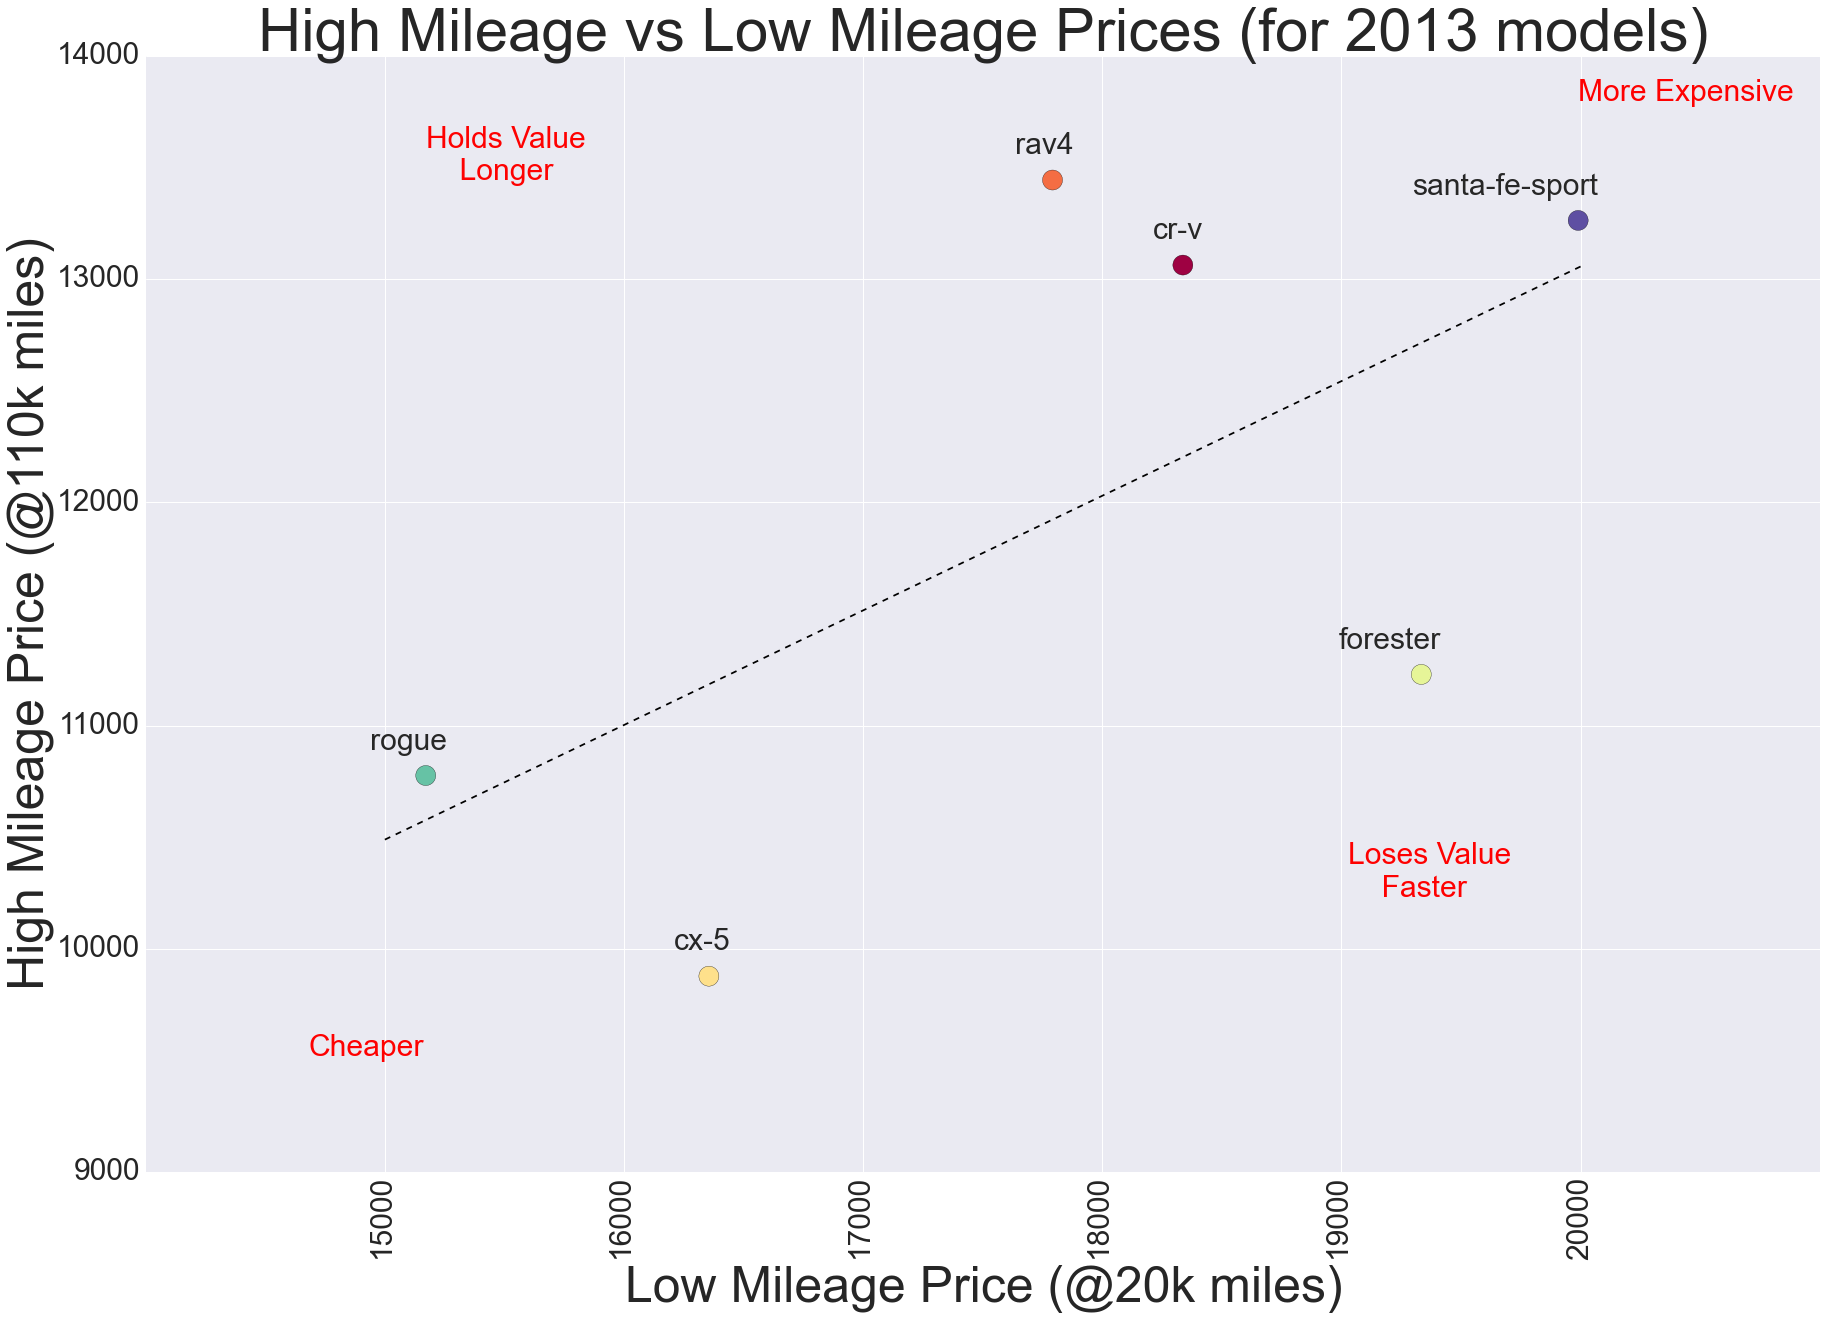

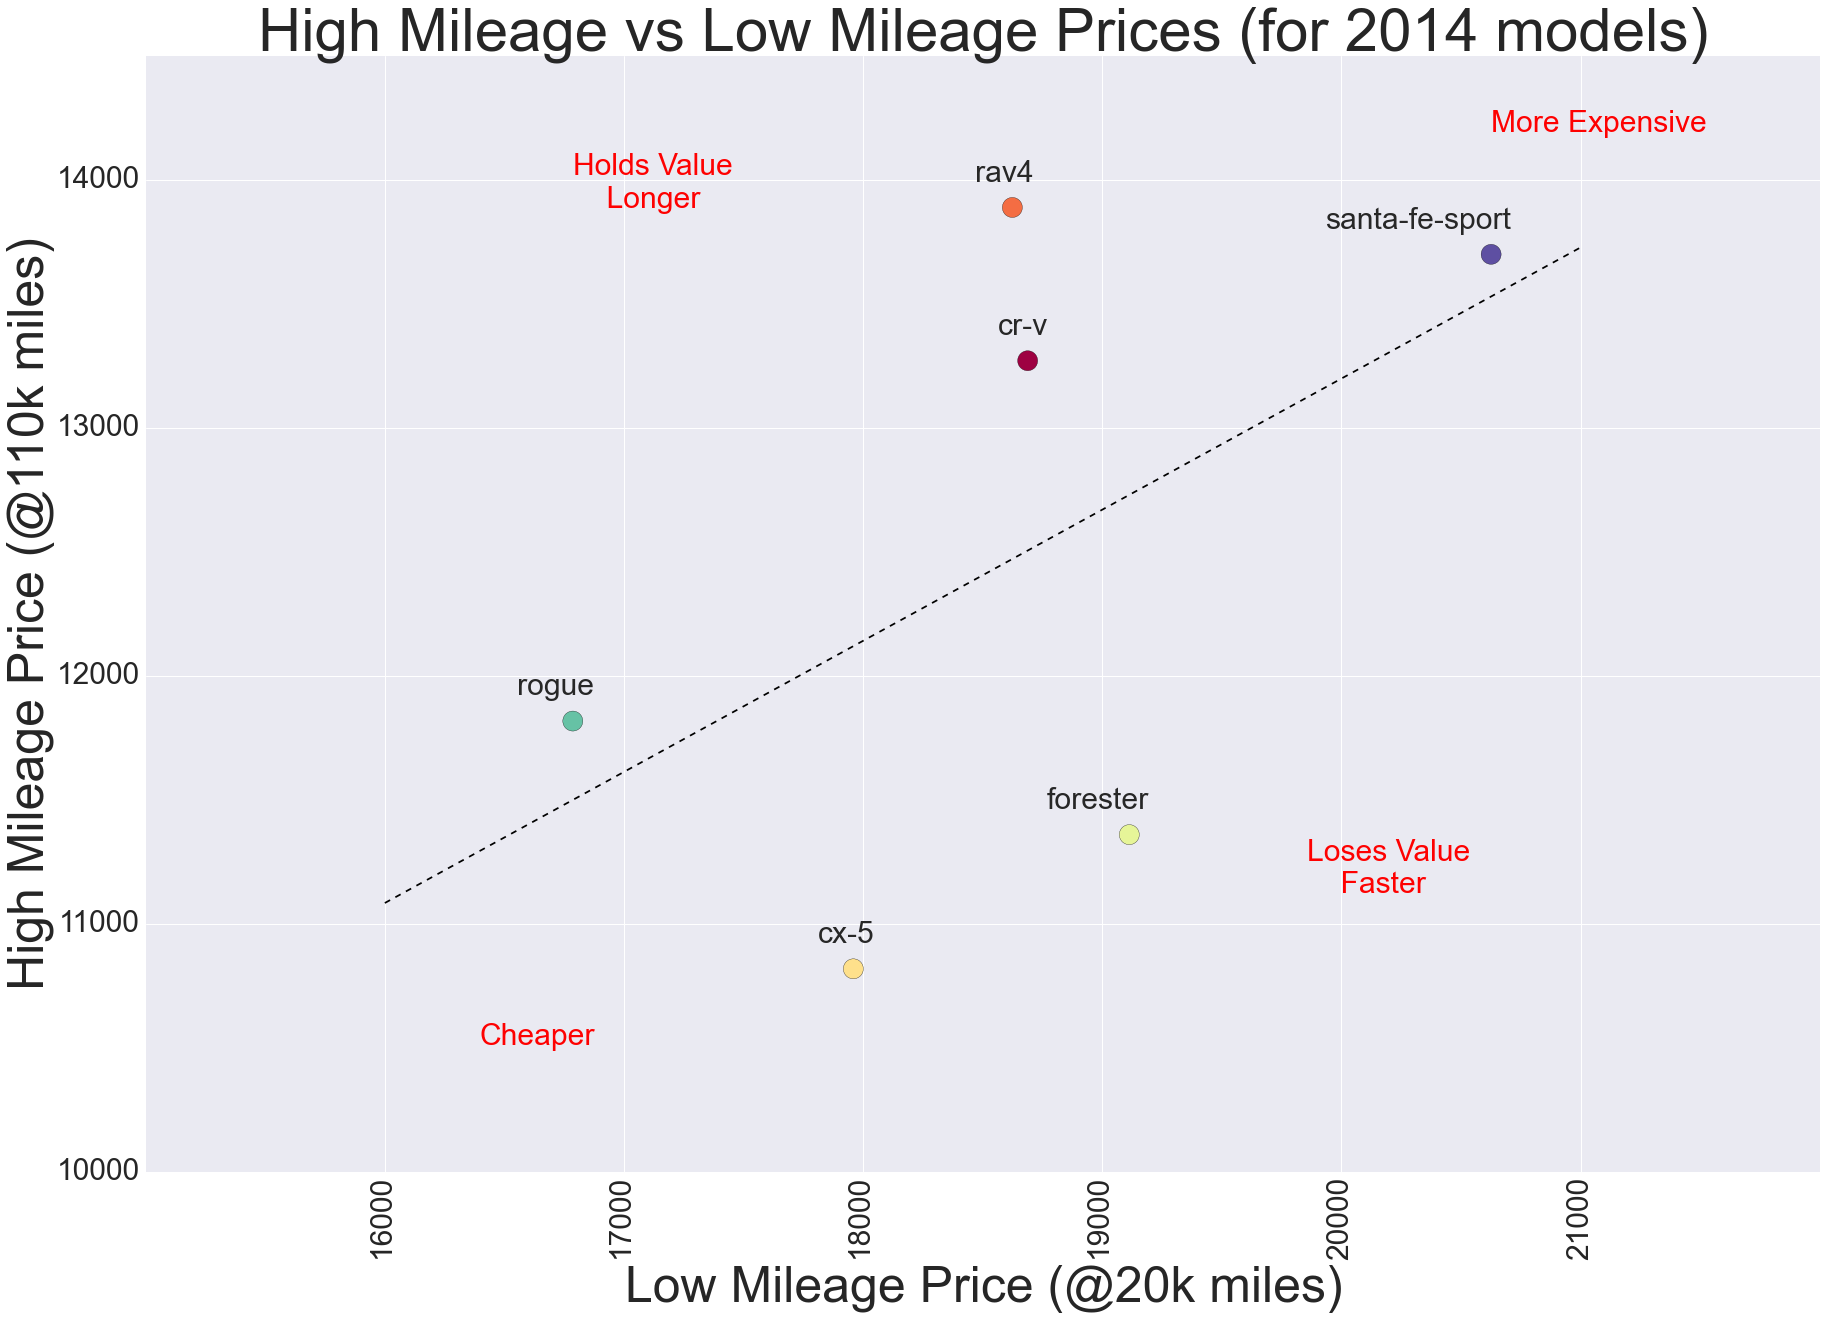

In [6]:
# make separate plots for each car model of the price trend vs mileage for all pricing options
for year in [2013, 2014]:
    fig, ax = plt.subplots()
    height = 20
    fig.set_figheight(height)
    width = 30
    fig.set_figwidth(width)
    ax.set_title('High Mileage vs Low Mileage Prices (for %d models)' % year, fontsize=width*2)
    ax.set_xlabel('Low Mileage Price (@20k miles)', fontsize=height*2.5)
    ax.set_ylabel('High Mileage Price (@110k miles)', fontsize=height*2.5)
    ax.tick_params(axis='y', labelsize=height*1.5)
    ax.tick_params(axis='x', labelsize=height*1.5)

    cars = df[df['year'] == year]['car'].unique()
    low_m_prices = df[(df['year'] == year) & (df['mileage'] == 20000)]['dealer'].values
    high_m_prices = df[(df['year'] == year) & (df['mileage'] == 110000)]['dealer'].values
    
    suv = [[], [], []]
    
    for i, car, low, high in zip(range(len(cars)), cars, low_m_prices, high_m_prices):
        suv[0].append(low)
        suv[1].append(high)
        suv[2].append(i*1.0/len(cars))
            
        plt.annotate(
                car, 
                xy = (low, high), xytext = (20, 20), fontsize=height*1.5, 
                textcoords = 'offset points', ha = 'right', va = 'bottom')
        
    plt.scatter(
        suv[0], 
        suv[1], 
        marker='o', 
        c=suv[2],
        s=height*20,
        cmap=plt.get_cmap('Spectral'))
    
    x_points = np.arange(1000*np.floor(low_m_prices.min()/1000), 
                            1000*np.ceil(low_m_prices.max()/1000)+1000, 1000)
    y_points = np.arange(1000*np.floor(high_m_prices.min()/1000), 
                            1000*np.ceil(high_m_prices.max()/1000)+1000, 1000)
    
    m, b = np.polyfit(low_m_prices,
                      high_m_prices, 1)
    plt.plot(x_points,
             x_points*m+b,
             c='k',
             linestyle='dashed')
        

    ax.set_yticks(y_points)
    plt.xticks(x_points, 
               range(int(1000*np.floor(low_m_prices.min()/1000)), 
                     int(1000*np.ceil(low_m_prices.max()/1000)+1000), 1000),
              rotation='vertical')
    
    x_min = low_m_prices.min()
    x_max = low_m_prices.max()
    dlt_x = x_max - x_min
    y_min = high_m_prices.min()
    y_max = high_m_prices.max()
    dlt_y = y_max - y_min
    
    plt.annotate('Loses Value\n    Faster', 
                 xy=(x_min+0.8*dlt_x, y_max-0.9*dlt_y),
                 color='r',
                 fontsize=height*1.5)
    plt.annotate('Holds Value\n    Longer', 
                 xy=(x_min, y_max),
                 color='r',
                 fontsize=height*1.5)
    plt.annotate('More Expensive', 
                 xy=(x_max+0*dlt_x, y_max+.1*dlt_y),
                 color='r',
                 fontsize=height*1.5)
    plt.annotate('Cheaper', 
                 xy=(x_min-.1*dlt_x, y_min-.1*dlt_y),
                 color='r',
                 fontsize=height*1.5)
    if year == 2013:
        plt.savefig('models_comparison', bbox_inches='tight')

    plt.show()

## What mileage of car gives the best value?

There's a lot of factors to account for if you want to compare value in detail between different cars - initial purchase price, resale value, maintenance costs, gas mileage, reliability compared to other cars - the list goes on. Unfortunately, in my first pass I didn't have all of this information (but stay tuned for a follow up post!).
We can still gain some insight, however, by simplifying things in two ways:
Only consider one car at a time. This way we can ignore factors that are only relative differences between car make/models.

Assume you will buy the car and keep it until it dies (as opposed to re-selling the car later). This only requires estimating a mileage at which you expect the car to die. That's much easier than looking at resale values at a later date with degrading condition of the car over time.

The question I CAN answer this way is "how does lifetime value of the car change with initial purchase mileage?". Should you spend more for a low mileage car, or save some money and buy a car with higher mileage? Which gives you the best bang for the buck in the long run?

With the above constraints, there are two big factors that make a difference in the lifetime value of the car: purchase price and maintenance cost. We'll look at each below.
Purchase price

We're interested in lifetime value of the car. This means averaging costs over ownership - how much do you end up paying for each mile you drive? Purchase price is pretty easy then. Just pick a mileage you think the car might die, subtract the mileage at purchase, then divide that in to the purchase price. Boom. You get price paid per mile in the lifetime of the car (shown in the following plots as "price per 10,000 miles" to be more intuitive).

The first set of plots will show how this value changes based on the purchase mileage for 3 different options for a "death" mileage. It shows this for both a Toyota Rav4 and a Honda CR-V.

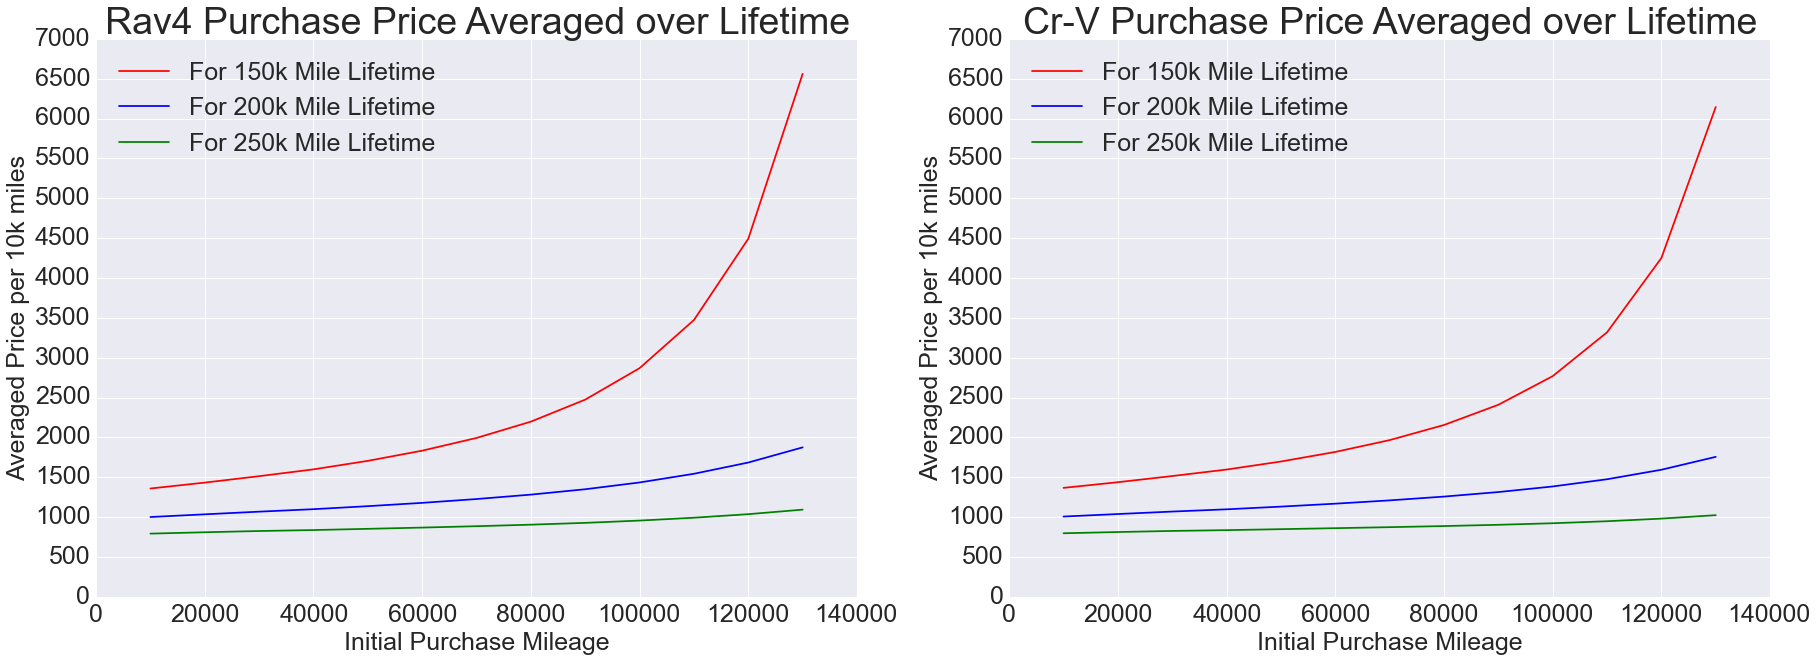

In [12]:
subset = mileage_cut(data, 130000)

cars = ['rav4', 'cr-v']
lifetime_mileages = [150000, 200000, 250000]

fig, ax = plt.subplots(1,len(cars))
height = 10
width = 30
fig.set_figheight(height)
fig.set_figwidth(width)
textheight = 25

year = 2014
colors = ['r', 'b', 'g']

for i, car in enumerate(cars):
    dealer = {}
    for j, lifetime_mileage in enumerate(lifetime_mileages):
        ax[i].set_title('%s Purchase Price Averaged over Lifetime' % (car.title()), fontsize=textheight*1.5)
        ax[i].set_xlabel('Initial Purchase Mileage', fontsize=textheight)
        ax[i].set_ylabel('Averaged Price per 10k miles', fontsize=textheight)
        ax[i].tick_params(axis='y', labelsize=textheight)
        ax[i].tick_params(axis='x', labelsize=textheight)
        ax[i].ticklabel_format()

        price_cost_per10k = subset[car][year].dealer/(lifetime_mileage-subset[car][year].mileage)*10000
        maint_cost_per10k = get_avg_maint_cost_per10k(subset[car][year].mileage, lifetime_mileage)
        
        dealer[lifetime_mileage] = ax[i].plot(subset[car][year].mileage, 
                                               price_cost_per10k, 
                                               c=colors[j])


    ax[i].legend([dealer[miles][0] for miles in lifetime_mileages], 
               ['For %dk Mile Lifetime'%(miles/1000) for miles in lifetime_mileages],
              fontsize=textheight,
              loc=0)

    if i == 0:
        y_min = ax[i].get_yticks()[0]
        y_max = ax[i].get_yticks()[-1]
        
    y_incriment = 500
    ax[i].set_yticks(np.arange(y_min, y_max+y_incriment, y_incriment))
        
plt.show()

Of course we want to pay less for our car, which means we want lower "Average Price" values. The trend of green cheaper than blue cheaper than red makes sense: if the car dies on you at 150k miles you going to end up having paid more per mile (worse value) and if it lasts until 250k you will have paid less per mile (better value).

Now, you may have noticed I just got finished explaining that you can only look at one car at a time and then promptly plotted two cars next to each other. I wanted to demonstrate why this comparison is dangerous. You can look closely at the Civic and see that you pay less price per mile than then Corolla (for the same lifetime). You may then be tempted to think the Civic is a better value. The problem with that is in the statement "for the same lifetime". Corollas hold more value at higher mileage BECAUSE they tend to last longer than Civics. So in reality, it may be more accurate to compare the 200k lifetime Civic with the 250k lifetime Corolla. In that case the Corolla has slightly better value. But without detailed information about how the reliability compares, we can't say for sure. Hence we just look at one car at a time so we can ignore those details.

So thinking about just one car at a time then, lets get back to our question - should you buy at higher mileage or lower mileage? From the above plots, we see that it's universally better to buy lower mileage. The initial price will be higher, but you get more bang for your buck in the long run if you can spend more up front. How strong this trend is depends on how long the car will last. But even if the car lasts 250k miles, there is a slight trend of worse value with higher purchase mileages (so maybe the purchase mileage doesn't matter AS much if the car is exceptionally reliable). And don't forget, this is only talking about value of the purchase price. We still haven't looked at maintenance cost yet.

The next plot shows a bit more we can learn about the value by comparing model year and purchase method (dealer vs private party) for an example 250k estimate lifetime:

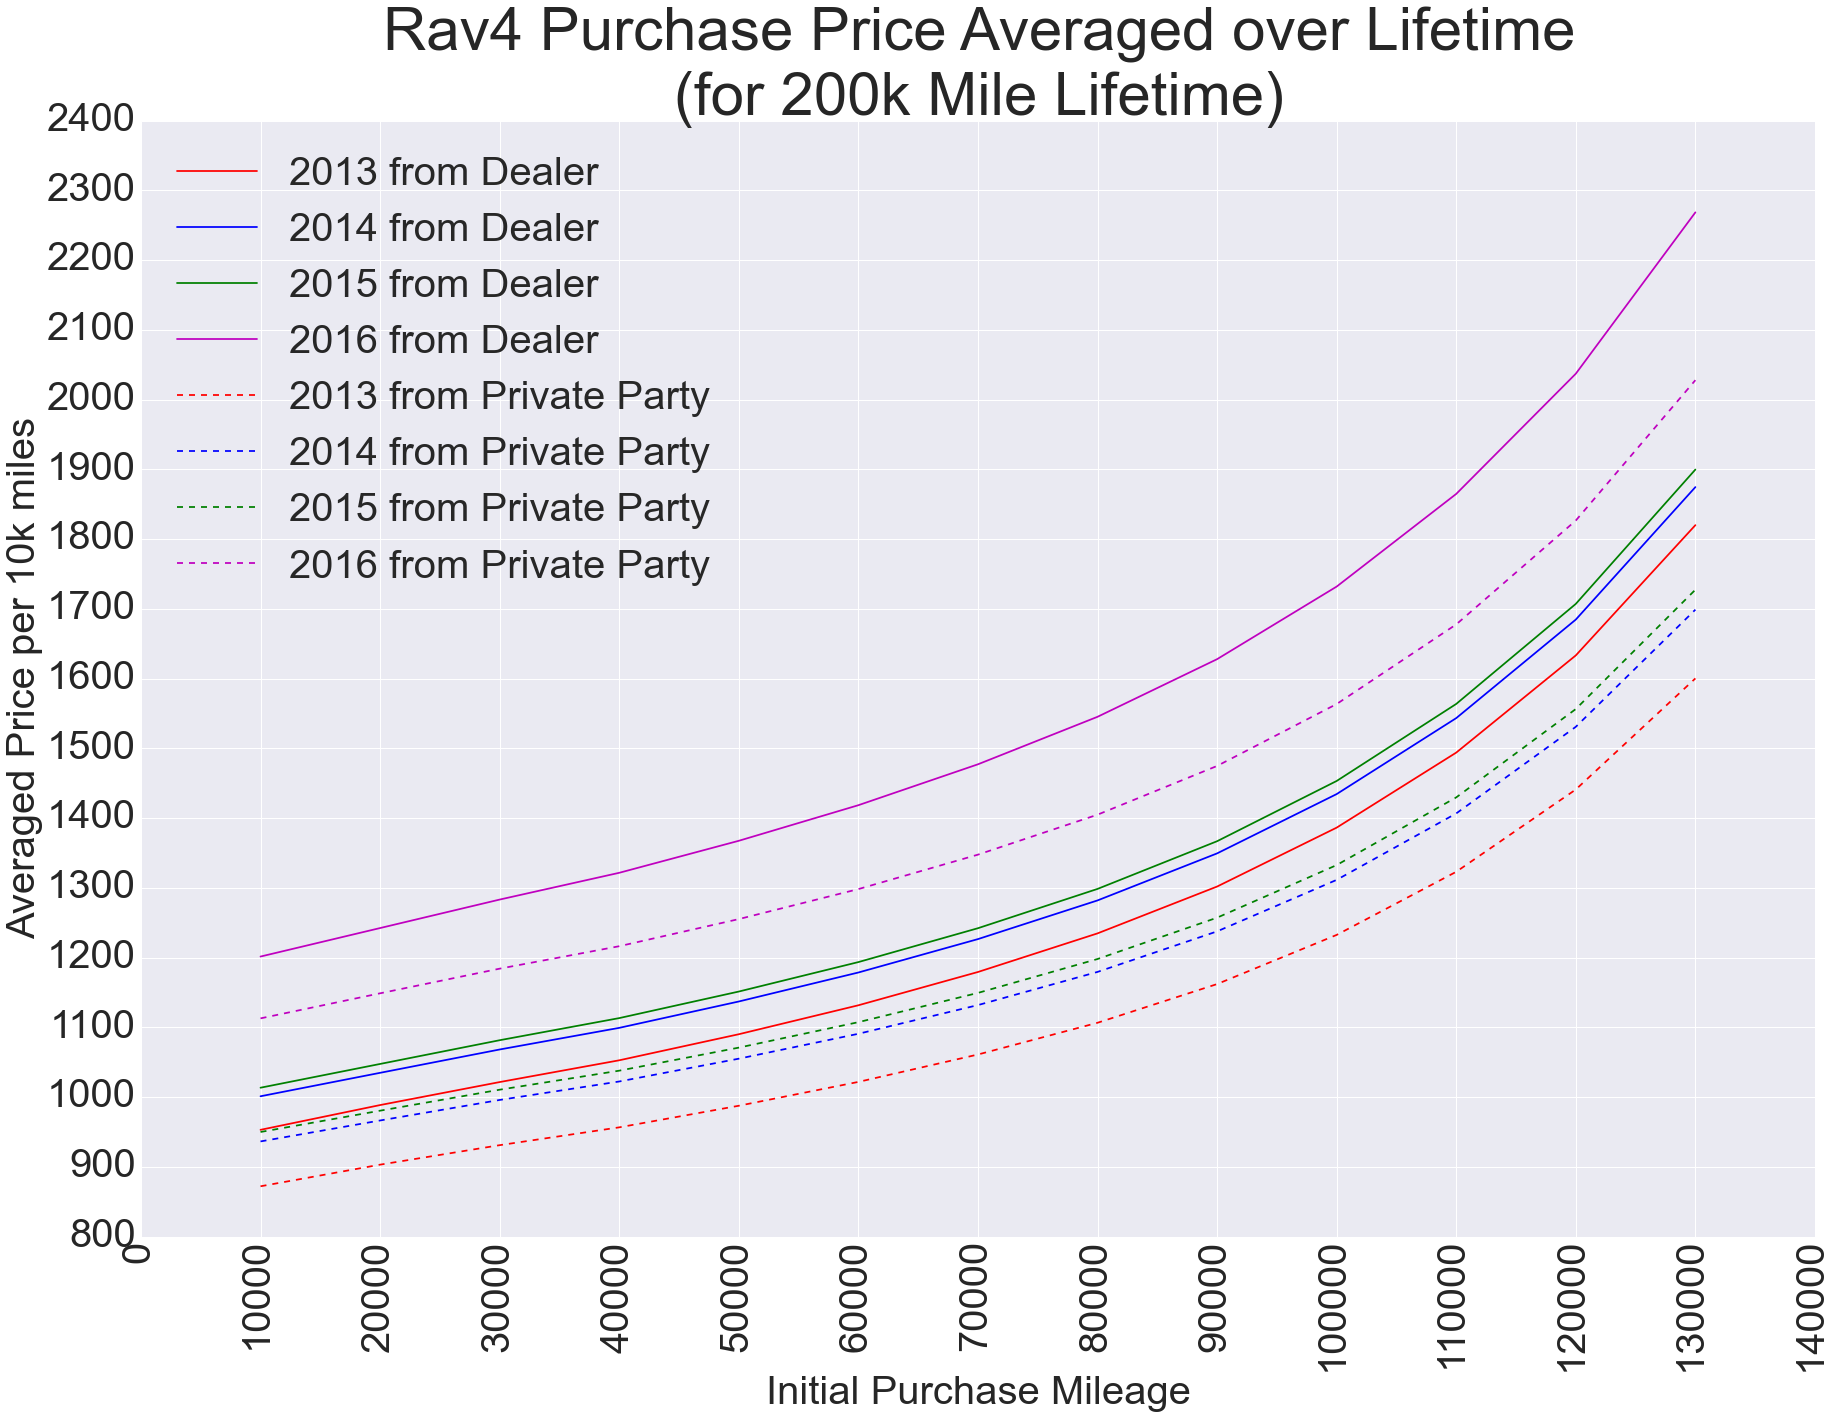

In [18]:
car = 'rav4'
lifetime_mileage = 200000

fig, ax = plt.subplots()
height = 20
width = 30
fig.set_figheight(height)
fig.set_figwidth(width)
textheight = 40


ax.set_title('%s Purchase Price Averaged over Lifetime\n(for %dk Mile Lifetime)' % (car.title(), lifetime_mileage/1000), fontsize=textheight*1.5)
ax.set_xlabel('Initial Purchase Mileage', fontsize=textheight)
ax.set_ylabel('Averaged Price per 10k miles', fontsize=textheight)
ax.tick_params(axis='y', labelsize=textheight)
ax.tick_params(axis='x', labelsize=textheight)
ax.ticklabel_format()

dealer = {}
private = {}
colors = {'dealer':{2013:'r', 2014:'b', 2015:'g', 2016:'m'},
          'private':{2013:'r', 2014:'b', 2015:'g', 2016:'m'}}

for year in [2013, 2014, 2015, 2016]:
    dealer[year] = ax.plot(subset[car][year].mileage, 
                           subset[car][year].dealer/(lifetime_mileage-subset[car][year].mileage)*10000, 
                           c=colors['dealer'][year])
    private[year] = ax.plot(subset[car][year].mileage, 
                            subset[car][year].pp_verygood/(lifetime_mileage-subset[car][year].mileage)*10000,
                            c=colors['private'][year],
                            linestyle='dashed')


ax.legend([dealer[2013][0], 
            dealer[2014][0], 
            dealer[2015][0],
            dealer[2016][0],
            private[2013][0],
            private[2014][0],
            private[2015][0], 
            private[2016][0]],
           ['2013 from Dealer', 
            '2014 from Dealer', 
            '2015 from Dealer',
            '2016 from Dealer',
            '2013 from Private Party',
            '2014 from Private Party',
            '2015 from Private Party',
            '2016 from Private Party'],
          fontsize=textheight,
          loc=0)

ax.set_yticks(np.arange(ax.get_yticks()[0], ax.get_yticks()[-1]+100, 100))
plt.xticks(np.arange(ax.get_xticks()[0], ax.get_xticks()[-1]+10000, 10000), 
           range(int(ax.get_xticks()[0]), int(ax.get_xticks()[-1])+10000, 10000),
          rotation='vertical')
        
plt.show()